# Boston Housing Prices

## Step 1: Data Analysis

#####  Data Source: [UCIMechineLearningRepository](https://archive.ics.uci.edu/ml/datasets/Housing). This data set contains 506 data points since 1978.  
**Features：**
1. `RM`: the number of rooms
2. `LSTAT`: the proportion of lower income group
3. `PTRATIO`: Student/teacher

**Object variable:**
1. `MEDV`: The median of house price

**Notice: **Data cleaning has already been done for improving data quality.
* Remove 16 data points which `'MEDV'= 50` since those data points contain lots of missing values 
* Remove 1 data points which `'RM'=8.78`(Outliers)
* `'MEDV'` has already been adjusted for inflation

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.model_selection import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1) # Delete 'MEDV'，axis=1 represents columns，axis=0 represents lines

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.head()

Boston housing dataset has 489 data points with 4 variables each.
      RM  LSTAT  PTRATIO      MEDV
0  6.575   4.98     15.3  504000.0
1  6.421   9.14     17.8  453600.0
2  7.185   4.03     17.8  728700.0
3  6.998   2.94     18.7  701400.0
4  7.147   5.33     18.7  760200.0


### 1.1 Descriptive statistics

In [3]:
# Method 1 with Numpy:

minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

# # Method 2 with pandas:
# df = pd.DataFrame(prices)
# print df.head()
# pd.set_option('precision', 3)
# print df.describe()

# # Method 3 with pandas:
# print "Max：",df.min()
# print "Min：",df.max()
# print "Average：",df.mean()# default lines,axis=1 columns
# print "Median：",df.median()
# print "Std：",df.std(ddof = 0) 
# This difference between Numpy and Pandas is pandas use N-1 to normalization the results and numpy don't do that.
# We can change the parameter ddof = 0, the numpy and pandas will share the same results.

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### 1.2 Feature observation
**Features：**
1. `RM`: the number of rooms
2. `LSTAT`: the proportion of lower income group
3. `PTRATIO`: Student/teacher

**Object variable:**
1. `MEDV`: The median of house price

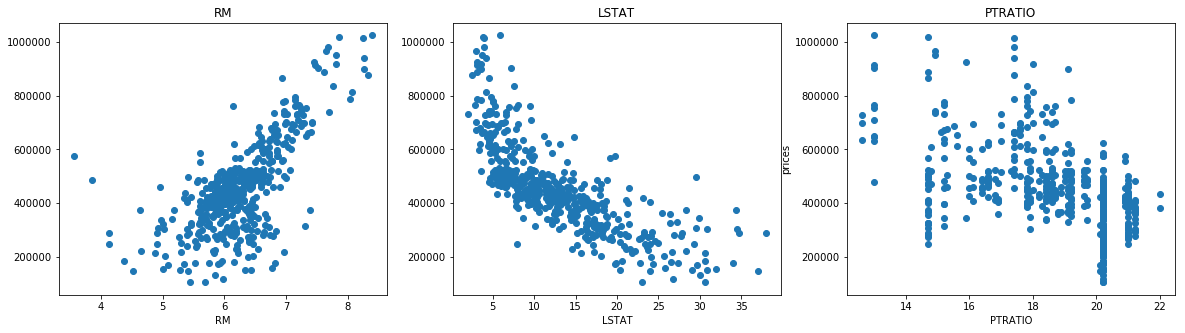

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'o')
    plt.title(col)
    plt.xlabel(col)
plt.ylabel('prices')

**Results: **  
`MEDV`increase as `RM` rise  
`MEDV`decrease as `LSTAT` rise  
*Not sure about the effect of student/teacher*

## Step 2: Model Construction

### 2.1 Definition of Measurement Index

Using $R^2$ as a measurement index  
With `r2_score` in `sklearn.metrics` to caculate
###### Expansion：http://scikit-learn.org/stable/modules/model_evaluation.html

In [5]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

#### Test $R^2$

Assume one dataset includes five real numerical data and five forecasters.  

| Real | Forecasters |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

In [43]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


### 2.2 Split up the dataset
Train set: 80% data  
Test set: 20% data
- Using `train_test_split` in `sklearn.model_selection` 
- Results: `X_train`,`X_test`,`y_train`,`y_test`。

In [6]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.2, random_state = 0)
# Success
print "Training and testing split was successful."

Training and testing split was successful.


### 2.3 Analyse the performance of the model
Judge decision Tree Model's performance with different parameters`'max_depth'` by observating learning curve

#### *Learning Curve*
Score = R<sup>2</sup> and the shadow area represent the uncertainty of the curve

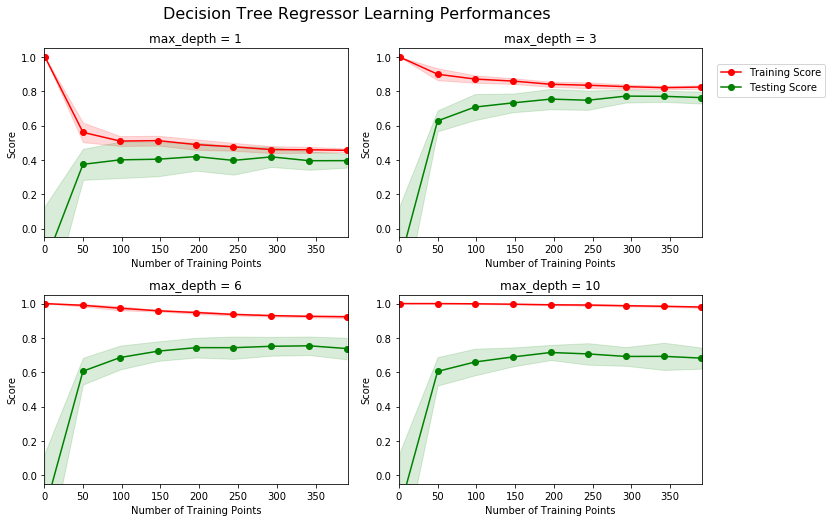

In [45]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

**Rsults: **  
According to the graph showing above, with the number of training points increase, the training score increases and the tesing score decrease. When the number of training points above 300, the training and tresting socres are converging.(max_depth= 1 or 3)If the max_depth = 6 or 10 two curves will not converge.

##### complexity curve

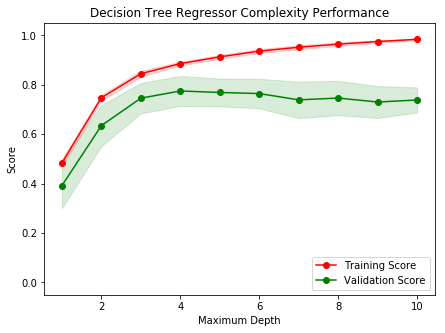

In [46]:
vs.ModelComplexity(X_train, y_train)

**Results: **  
When the max_depth = 1, the variance is small and the deviation is huge.  
When the max_depth = 10, the variance is huge and the deviation is small.

##### Thus, I assume the model have the best performance when the max_depth is 4

### 2.4 Training model
* Construction a DecisionTree model `DecisionTreeRegressor()`
* Using `ShuffleSplit()` to do cross-validation
* Using `GridSearchCV` and cross-validation to decided the best parameters(max_depth)

In [50]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    # Create a decision tree regressor object
    regressor =  DecisionTreeRegressor()
    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 11)}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric) 
    # performance_metric have two parameters the one is real value and another is forcaster, return score(R^2)
    # Create the grid search object
    grid = GridSearchCV(regressor, params,scoring_fnc,cv = cv_sets)
    # 传递四个参数 评估模型, 参数字典,得分矩阵，切分方法
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [51]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)
# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


**Answer: **  
Optimal parameter `max_depth` = 4

## Step 3:  House prices predictation 

| features | Sample 1 | Sample 2 | Sample 3 |
| :---: | :---: | :---: | :---: |
| `RM` | 5 | 4 | 8 |
| `LSTAT` | 17% | 32% | 3% |
| `Student/teacher` | 15：1 | 22：1 | 12：1 |


In [52]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3
# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $391,183.33
Predicted selling price for Client 2's home: $189,123.53
Predicted selling price for Client 3's home: $942,666.67
